# Breast Cancer Prediction with XGBoost
_**Using Gradient Boosted Trees to Predict breast cancer with features derived from breast mass images**_

---

## Contents

1. [Background](#Background)
2. [Notebook Setup](#notebook_setup)
3. [Data Wrangling](#data_wrangling)
4. [Dataset Preparation](#dataset_preparation)
5. [Training](#Training)
6. [Hosting](#Hosting)
  1. [Evaluate](#Evaluate)
7. [(Optional) Clean-up](#cleanup)
8. [Extensions](#Extensions)
  1. [Hyperparameter Optimization](#hyperparameter_optimization)
  1. [(Optional) Final Clean-up](#cleanupfinal)

---
<a id = "Background"></a>

## Background

This notebook illustrates the use of SageMaker's built-in XGBoost algorithm for binary classification.
XGBoost uses decision trees to build a predictive model.

Also demonstrated is Hyperparameter optimization as well as using the best model from HPO to instantiate a new endpoint

### Why XGBoost and not Logistic Regression?

Whilst logistic regression is often used for classification exercises, it has some drawbacks. For example, additional feature engineering is required to deal with non-linear features.

XGBoost (an implementation of Gradient Boosted Trees) offers several benefits including naturally accounting for non-linear relationships between features and the target variable, as well as accommodating complex interactions between features.
Decision Tree algorithms such as XGBoost also have the added benefit of being able to deal with missing values in both the training dataset as well as unseen samples that are being used for inference.

Amazon SageMaker provides an XGBoost container that we can use to train in a managed, distributed setting, and then host as a real-time prediction endpoint

---
<a id = "notebook_setup"></a>

## Notebook Setup

_This notebook was created and tested on an ml.t2.medium notebook instance._


### SageMaker SDK version
At the time of preparing this notebook; SageMaker is transitioning from V1 SDK to V2<br>
First check which version of the SDK we are running

In [1]:
import sagemaker
sagemaker.__version__

'2.54.0'

If SageMaker version is below 2.5.5, uncomment and execute the command in the cell below.
Note: You will need to restart your kernel after executing the command below

In [3]:
#pip install --upgrade sagemaker

### Import dependencies

Let's start by specifying:

- The S3 bucket and prefix that you want to use for training and model data.  This should be within the same region as the Notebook Instance, training, and hosting.
- The SageMaker role arn used to give learning and hosting access to your data. The snippet below will use the same role used by your SageMaker notebook instance. If you wish to use a different role, specify the full ARN of a role with the SageMakerFullAccess policy attached.

In [4]:

# Define IAM role
import boto3
import re
from sagemaker import get_execution_role

region = boto3.Session().region_name

# Define IAM role
role = get_execution_role()

sess = sagemaker.Session()

#bucket = ''  # <uncomment and change to your own bucket if you don't want to use the default bucket>
bucket = sess.default_bucket()  
print(sagemaker.Session().default_bucket())
prefix = 'sagemaker/xgboost-bc' # modify to your own path if desired


sagemaker-ap-southeast-2-263461971145


Next, we'll import the Python libraries we'll need for examining our data

In [5]:
# import io

import numpy as np                                # For matrix operations and numerical processing
import pandas as pd                               # For munging tabular data
import matplotlib.pyplot as plt                   # For charts and visualizations
from IPython.display import Image                 # For displaying images in the notebook
from IPython.display import display               # For displaying outputs in the notebook
import time                                       # For labeling SageMaker models, endpoints, etc.
from time import gmtime, strftime                 # For labeling SageMaker models, endpoints, etc.
import sys                                        # For writing outputs to notebook
import math                                       # For ceiling function
import json                                       # For parsing hosting outputs
import os                                         # For manipulating filepath names
import zipfile                                    # Amazon SageMaker's Python SDK provides many helper functions

---
<a id='data_wrangling'></a>

## Data Wrangling

For this illustration, we have taken an example for breast cancer prediction using UCI'S breast cancer diagnostic data set available at https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Diagnostic%29. The data set is also available on Kaggle at https://www.kaggle.com/uciml/breast-cancer-wisconsin-data. The purpose here is to use this data set to build a predictve model of whether a breast mass image indicates benign or malignant tumor. 

You can find out all the details of this dataset here: https://www.kaggle.com/uciml/breast-cancer-wisconsin-data

Let's download the data and save it in the local folder so that we can take a look at it.

In [6]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data

--2021-09-06 03:17:52--  https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 124103 (121K) [application/x-httpd-php]
Saving to: ‘wdbc.data.2’

wdbc.data.2         100%[===================>] 121.19K   276KB/s    in 0.4s    

2021-09-06 03:17:54 (276 KB/s) - ‘wdbc.data.2’ saved [124103/124103]



The dataset we downloaded does not have column headings; however this information is available at the source

More information about this dataset can be found here: https://www.kaggle.com/uciml/breast-cancer-wisconsin-data
Sample images used in this dataset can be seen here: ftp://ftp.cs.wisc.edu/math-prog/cpo-dataset/machine-learn/cancer/cancer_images

- `id`: ID number
- `diagnosis`: The diagnosis of breast tissues (M = malignant, B = benign)
- `radius_mean`: mean of distances from center to points on the perimeter
- `texture_mean`: standard deviation of gray-scale values
- `perimeter_mean`: mean size of the core tumor
- `area_mean`: area of the core tumor
- `smoothness_mean`: mean of local variation in radius lengths
- `compactness_mean`: mean of perimeter^2 / area - 1.0
- `concavity_mean`: mean of severity of concave portions of the contour
- `concave points_mean`: mean for number of concave portions of the contour
- `symmetry_mean`: mean for symmetry between left and right breasts
- `fractal_dimension_mean`: mean for "coastline approximation" - 1
- `radius_se`: standard error for the mean of distances from center to points on the perimeter
- `texture_se`: standard error for standard deviation of gray-scale values
- `perimeter_se`: standard error for size of the core tumor
- `area_se`: standard error for area of the core tumor
- `smoothness_se`: standard error for local variation in radius lengths
- `compactness_se`: standard error for perimeter^2 / area - 1.0
- `concavity_se`: standard error for severity of concave portions of the contour
- `concave points_se`: standard error for number of concave portions of the contour
- `symmetry_se`: standard error for symmetry between left and right breasts
- `fractal_dimension_se`: standard error for "coastline approximation" - 1
- `radius_worst`: "worst" or largest mean value for mean of distances from center to points on the perimeter
- `texture_worst`: "worst" or largest mean value for standard deviation of gray-scale values
- `perimeter_worst`: "worst" or largest mean value for size of the core tumor
- `area_worst`: "worst" or largest mean value for area of the core tumor
- `smoothness_worst`: "worst" or largest mean value for local variation in radius lengths
- `compactness_worst`: "worst" or largest mean value for perimeter^2 / area - 1.0
- `concavity_worst`: "worst" or largest mean value for severity of concave portions of the contour
- `concave points_worst`: "worst" or largest mean value for number of concave portions of the contour
- `symmetry_worst`: "worst" or largest mean value for standard error for symmetry between left and right breasts
- `fractal_dimension_worst`: "worst" or largest mean value for "coastline approximation" - 1


If we load this CSV data into a pandas dataframe, we can easily take a closer look

Note that this dataset doesn't have a header line, so we will add the column names to the pandas dataframe ourselves

In [7]:
import pandas as pd
col_names = ["id","diagnosis","radius_mean","texture_mean","perimeter_mean","area_mean","smoothness_mean",
                "compactness_mean","concavity_mean","concave points_mean","symmetry_mean","fractal_dimension_mean",
                "radius_se","texture_se","perimeter_se","area_se","smoothness_se","compactness_se","concavity_se",
                "concave points_se","symmetry_se","fractal_dimension_se","radius_worst","texture_worst",
                "perimeter_worst","area_worst","smoothness_worst","compactness_worst","concavity_worst",
                "concave points_worst","symmetry_worst","fractal_dimension_worst"]
breastcancer = pd.read_csv('./wdbc.data', header=None, names=col_names)
breastcancer

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,926424,M,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,926682,M,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,926954,M,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,927241,M,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


The breast cancer dataset is quite small, with only 569 records, where each record uses 32 attributes to describe the profile of a breast mass.
Features are computed from a digitized image of a fine needle aspirate (FNA) of a breast mass. They describe characteristics of the cell nuclei present in the image

The diagnosis column is our target column. Lets take a look at the diagnosis distribution in both absolute and normalised forms:

In [8]:
display(pd.crosstab(index=breastcancer['diagnosis'], columns='% observations'))
display(pd.crosstab(index=breastcancer['diagnosis'], columns='% observations', normalize='columns'))

col_0,% observations
diagnosis,
B,357
M,212


col_0,% observations
diagnosis,
B,0.627417
M,0.372583


So 63% of our samples are benign and 37% are malignant.

### Feature Distribution

Let's have a look at the distrubution of the numerical features

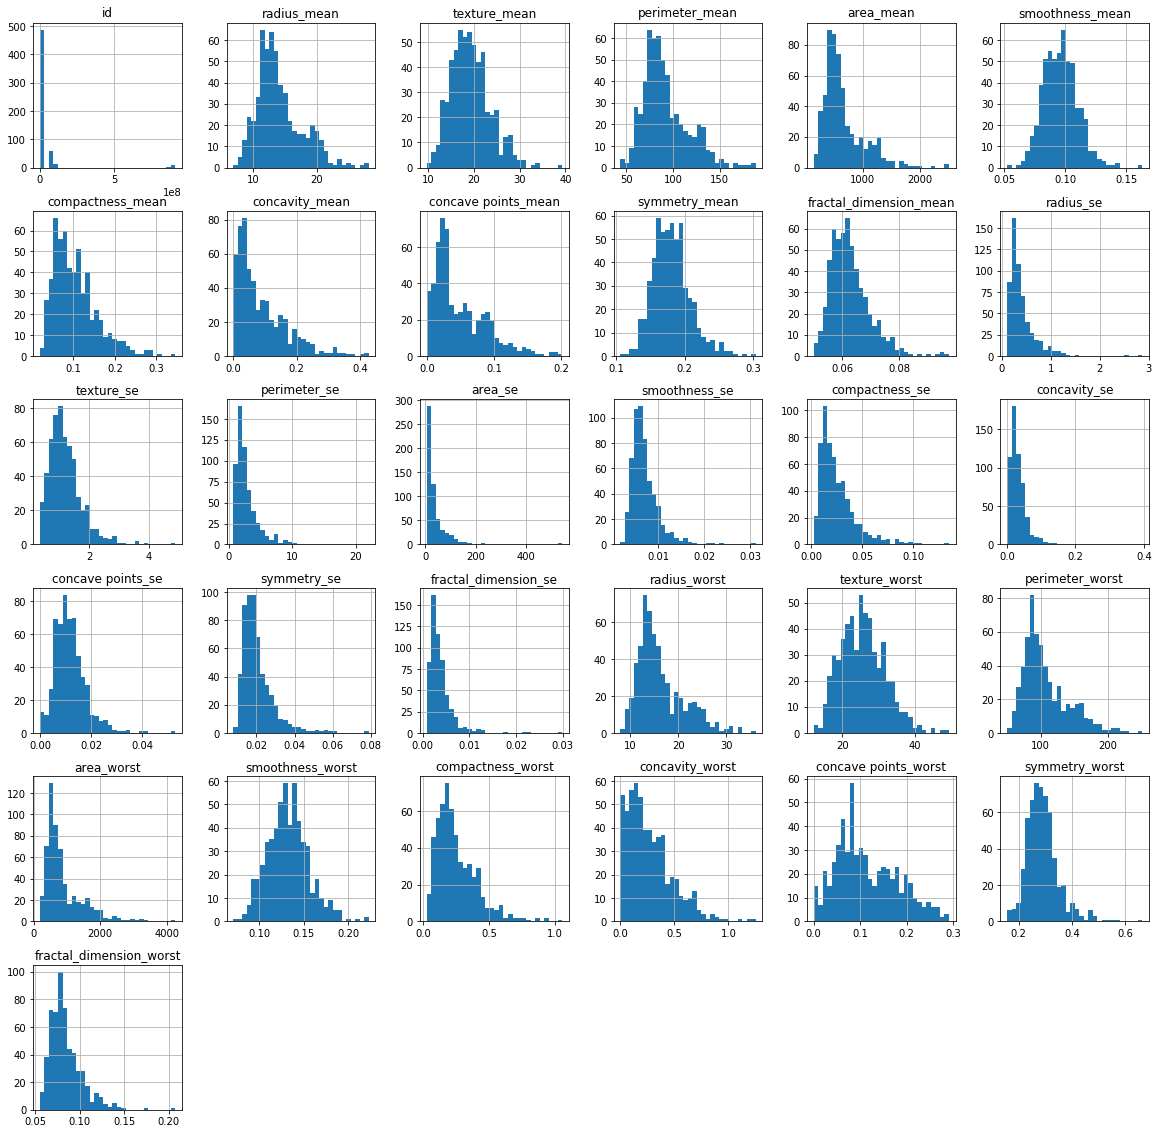

In [9]:

%matplotlib inline
hist = breastcancer.hist(bins=30, sharey=False, figsize=(20, 20))

From these histograms we can see that:
- Most of the numeric features are following a gaussian distribution
- `id` should not be included as a feature as it is irrelevant for predicting a diagnosis (Note: if we were going to keep `id`, it should be converted to non-numeric) 


We will drop the `id` column from the dataset:


In [10]:
breastcancer = breastcancer.drop(['id'], axis=1)

#### Note for future reference:
There may be scenarios where you have a numeric field like `id` that did add some non-numeric value. <br>
A good example would be if the first N characters of patient ID indicated the country or state where the patient was located and you wanted to see if this location had any bearing on the diagnosis. <br>
In such a case you would convert the field to a string:
<pre><code>breastcancer['id'] = breastcancer['id'].astype(object)</code></pre>
and extract the pertinant information. <br>
You would then treat that field as a categorical field. <br>
These categorical fields would later be converted to indicator variables using the pandas 'get_dummies' method


To take a look at the relationship between any categorical fields and the final diagnosis, you would use the following cross-tabulation report: 
<pre><code>for column in breastcancer.select_dtypes(include=['object']).columns:
    if column != 'diagnosis':
        display(pd.crosstab(index=breastcancer[column], columns=breastcancer['diagnosis'], normalize='columns'))
</code></pre>

### Direct relationship between features and diagnosis

Now we will look at the direct relationship between numeric (non-object) values and diagnosis. We do this by plotting a histogram for every numeric value.
We divide our samples into `bins`. The X-axis represents the bins and the Y-axis represents how many samples fall into each bin.
By forcing the benign and malignant graphs to share the same X and Y scale it is easier to visualise which bins are more populated between the two diagnoses.

Feel free to adjust the number of bins being plotted by the histogram and view the effect.

radius_mean


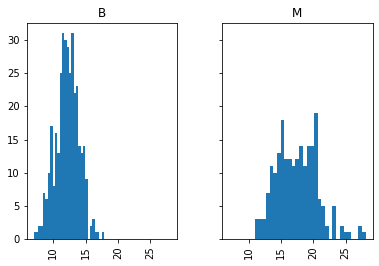

texture_mean


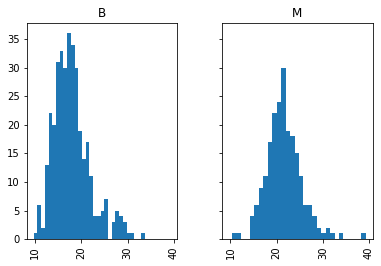

perimeter_mean


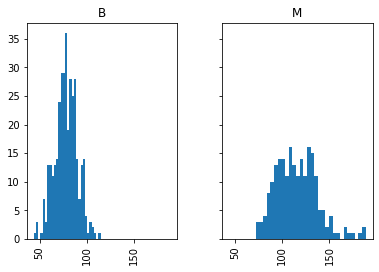

area_mean


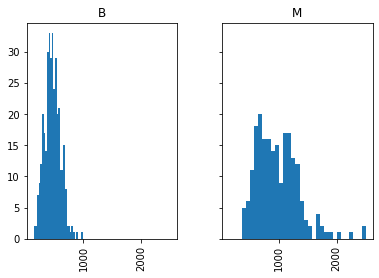

smoothness_mean


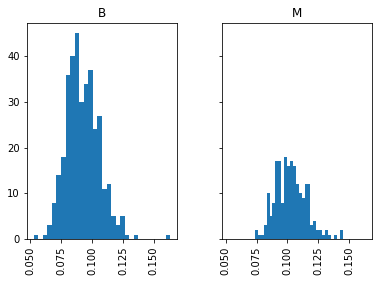

compactness_mean


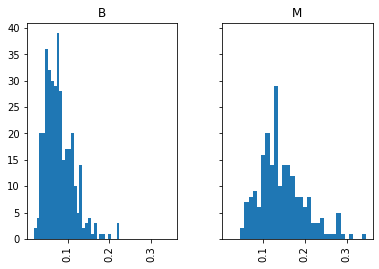

concavity_mean


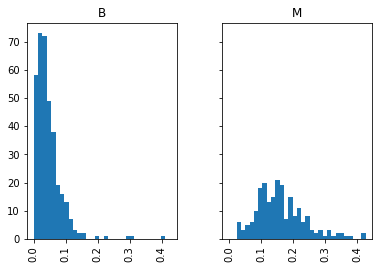

concave points_mean


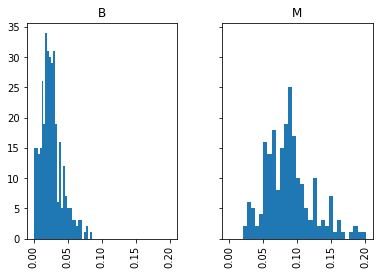

symmetry_mean


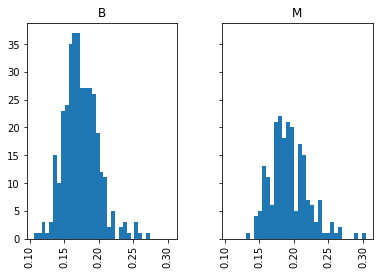

fractal_dimension_mean


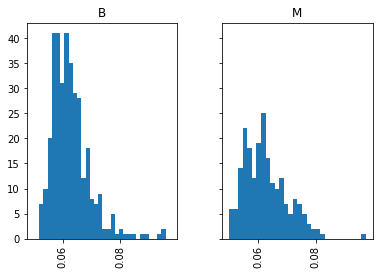

radius_se


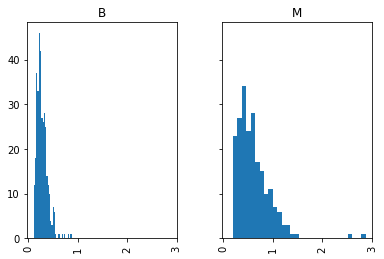

texture_se


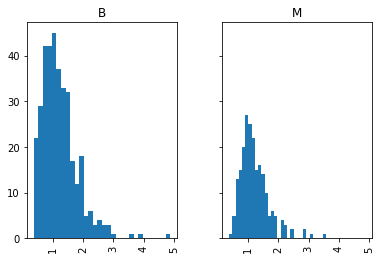

perimeter_se


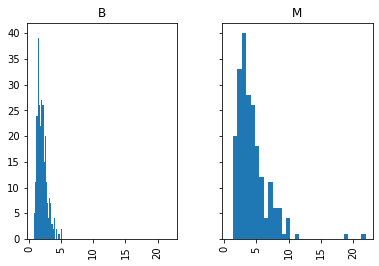

area_se


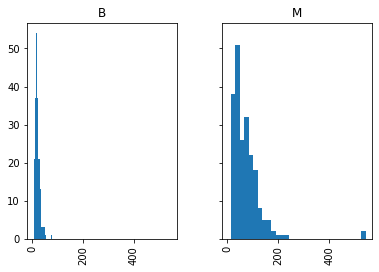

smoothness_se


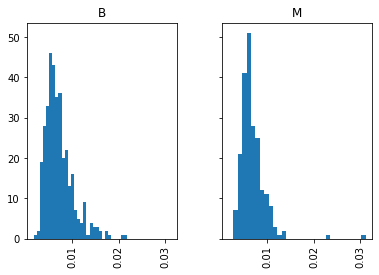

compactness_se


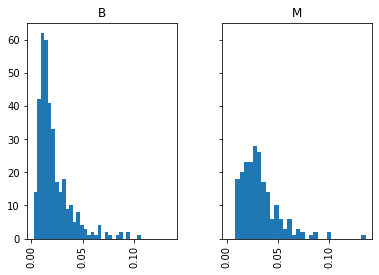

concavity_se


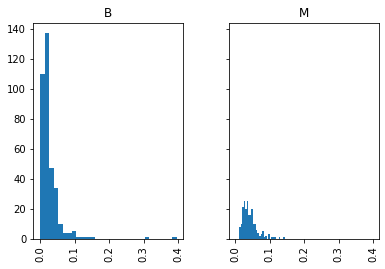

concave points_se


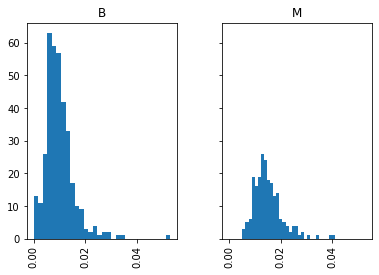

symmetry_se


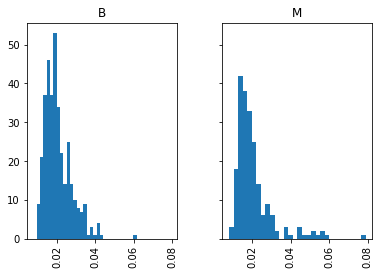

fractal_dimension_se


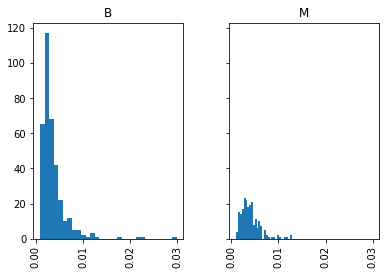

radius_worst


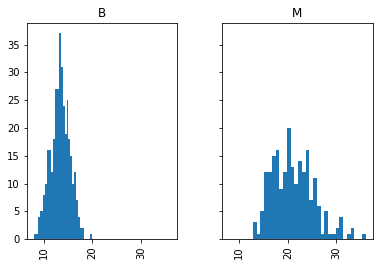

texture_worst


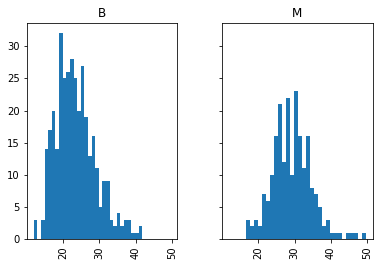

perimeter_worst


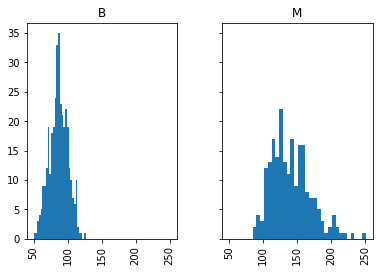

area_worst


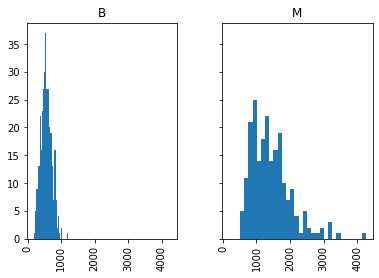

smoothness_worst


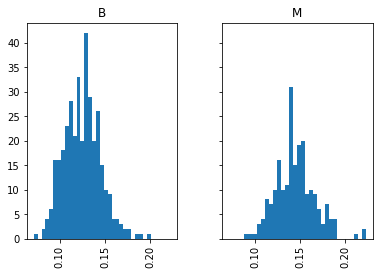

compactness_worst


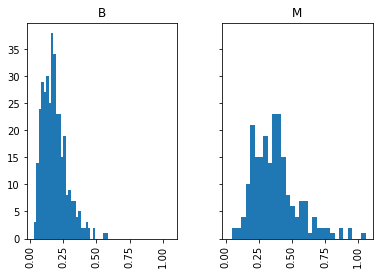

concavity_worst


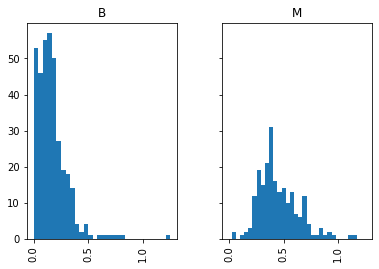

concave points_worst


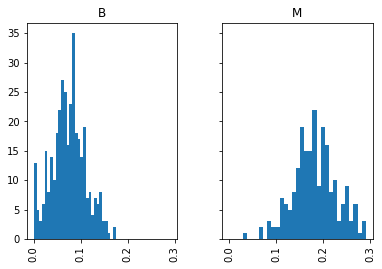

symmetry_worst


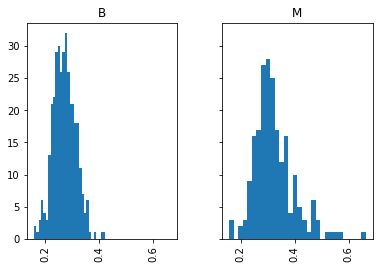

fractal_dimension_worst


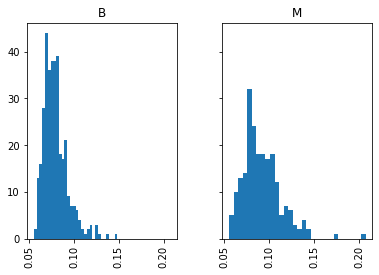

In [11]:
for column in breastcancer.select_dtypes(exclude=['object']).columns:
    print(column)
    hist = breastcancer[[column, 'diagnosis']].hist(by='diagnosis', sharey=True, sharex=True, bins=30)
    plt.show()

What can we infer from these relationships?

We see that malignant diagnosis appear to have higher values (extend further to the right on the X axis) for the following features:
- radius_mean
- perimeter_mean
- area_mean
- compactness_mean
- concavity_mean
- concave points_mean
- radius_se
- area_se
- radius_worst
- texture_worst
- perimeter_worst
- area_worst
- compactness_worst
- concavity_worst
- concave points_worst

We see similar distributions for features such as `radius_mean`, `perimeter_mean` and `area_mean` for both malignant and benign diagnosis. This makes sense as each of these features are related to the size of the tumour.

Let's look at correlations using a scatter matrix

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
radius_mean,1.000000,0.323782,0.997855,0.987357,0.170581,0.506124,0.676764,0.822529,0.147741,-0.311631,...,0.969539,0.297008,0.965137,0.941082,0.119616,0.413463,0.526911,0.744214,0.163953,0.007066
texture_mean,0.323782,1.000000,0.329533,0.321086,-0.023389,0.236702,0.302418,0.293464,0.071401,-0.076437,...,0.352573,0.912045,0.358040,0.343546,0.077503,0.277830,0.301025,0.295316,0.105008,0.119205
perimeter_mean,0.997855,0.329533,1.000000,0.986507,0.207278,0.556936,0.716136,0.850977,0.183027,-0.261477,...,0.969476,0.303038,0.970387,0.941550,0.150549,0.455774,0.563879,0.771241,0.189115,0.051019
area_mean,0.987357,0.321086,0.986507,1.000000,0.177028,0.498502,0.685983,0.823269,0.151293,-0.283110,...,0.962746,0.287489,0.959120,0.959213,0.123523,0.390410,0.512606,0.722017,0.143570,0.003738
smoothness_mean,0.170581,-0.023389,0.207278,0.177028,1.000000,0.659123,0.521984,0.553695,0.557775,0.584792,...,0.213120,0.036072,0.238853,0.206718,0.805324,0.472468,0.434926,0.503053,0.394309,0.499316
compactness_mean,0.506124,0.236702,0.556936,0.498502,0.659123,1.000000,0.883121,0.831135,0.602641,0.565369,...,0.535315,0.248133,0.590210,0.509604,0.565541,0.865809,0.816275,0.815573,0.510223,0.687382
concavity_mean,0.676764,0.302418,0.716136,0.685983,0.521984,0.883121,1.000000,0.921391,0.500667,0.336783,...,0.688236,0.299879,0.729565,0.675987,0.448822,0.754968,0.884103,0.861323,0.409464,0.514930
concave points_mean,0.822529,0.293464,0.850977,0.823269,0.553695,0.831135,0.921391,1.000000,0.462497,0.166917,...,0.830318,0.292752,0.855923,0.809630,0.452753,0.667454,0.752399,0.910155,0.375744,0.368661
symmetry_mean,0.147741,0.071401,0.183027,0.151293,0.557775,0.602641,0.500667,0.462497,1.000000,0.479921,...,0.185728,0.090651,0.219169,0.177193,0.426675,0.473200,0.433721,0.430297,0.699826,0.438413
fractal_dimension_mean,-0.311631,-0.076437,-0.261477,-0.283110,0.584792,0.565369,0.336783,0.166917,0.479921,1.000000,...,-0.253691,-0.051269,-0.205151,-0.231854,0.504942,0.458798,0.346234,0.175325,0.334019,0.767297


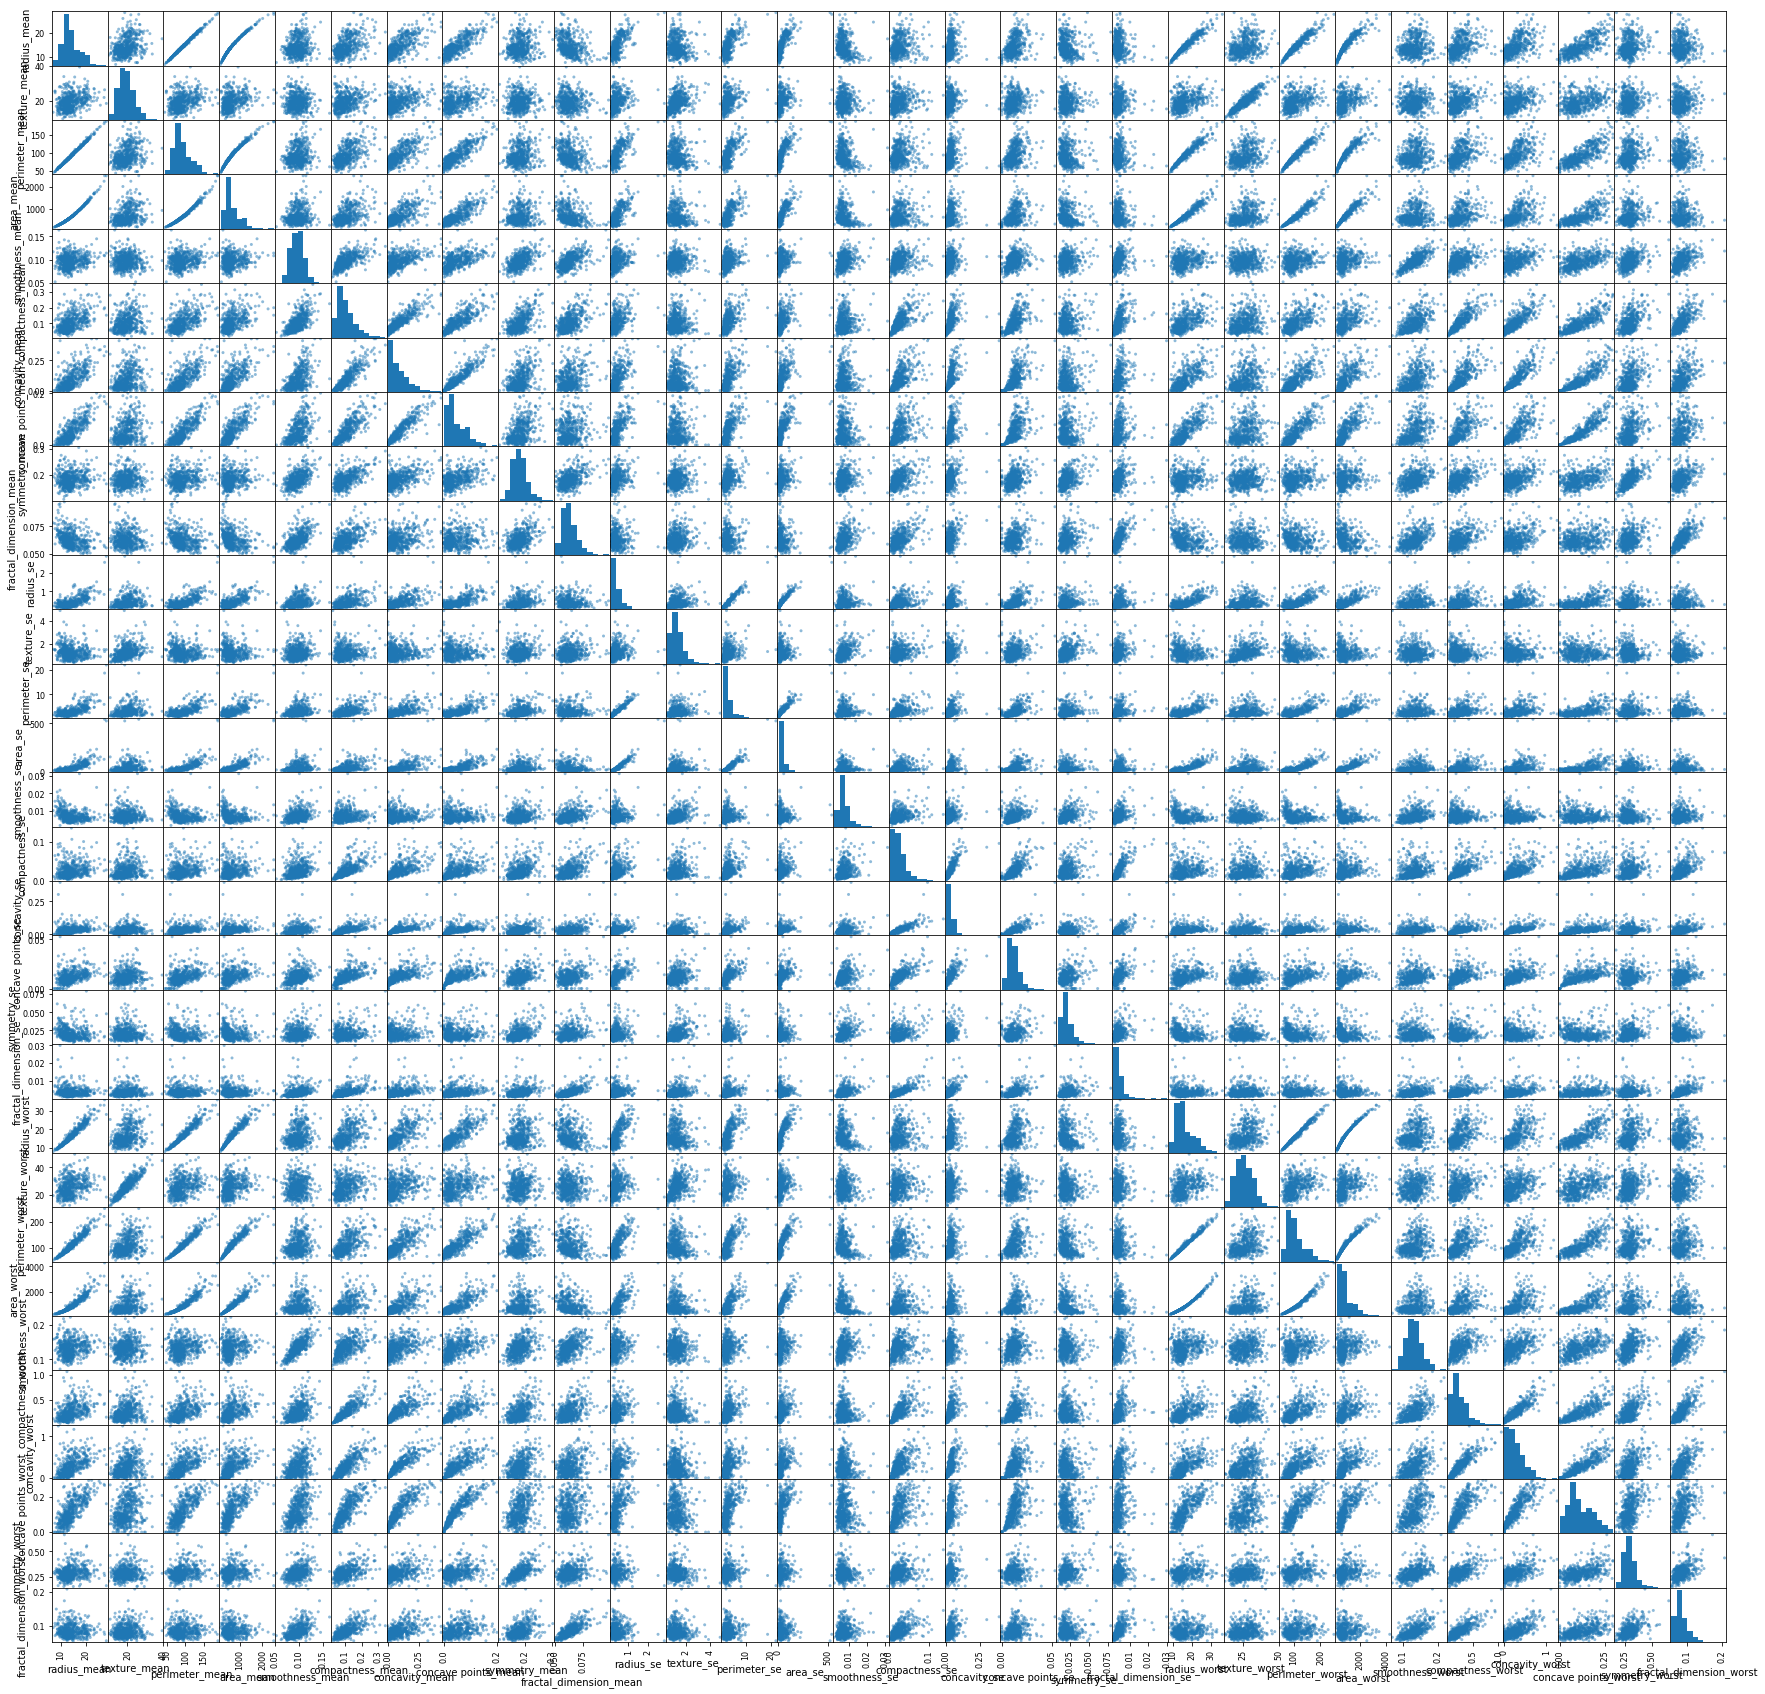

In [12]:
import matplotlib.pyplot as plt


display(breastcancer.corr())
pd.plotting.scatter_matrix(breastcancer, figsize=(30, 30))
plt.show()

In the scatter matrix, such strongly correlated features are indicated by a diagonal line running from bottom left to top right. In the correlation matrix, such relationships are indicated by a correlation value close to 1.

In many cases it can be a good idea to remove one element of a highly correlated feature pair. 

`radius_mean` has high correlation (>98%) with both `perimeter_mean` and `area_mean`
`radius_worst` has high correlation (>98%) with both `perimeter_worst` and `area_worst`

To simplify our model, we will drop `perimeter_mean`, `area_mean`, `perimeter_worst` and `area_worst`

In [13]:
breastcancer = breastcancer.drop(['perimeter_mean', 'area_mean', 'perimeter_worst', 'area_worst'], axis=1)

---
<a id='dataset_preparation'></a>

## Dataset Preparation For XGBoost

Now that we have a clean dataset (and have potentially removed some unneccessary columns), we can prepare the dataset for XGBoost. 

Amazon SageMaker XGBoost can train on data in either a CSV or LibSVM format.  For this example, we'll stick with CSV.  It should:
- Contain only numeric values
- Have the predictor variable in the first column
- Not have a header row

We will also
- Shuffle the dataset
- Split the dataset into training, validation and testing sets

### Step 1: Convert our label (the field we are trying to predict) to numeric - where 0 means B (benign) and 1 means M (malignant)

Ref: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Categorical.html


In [14]:
breastcancer.diagnosis = pd.Categorical(breastcancer.diagnosis).codes
breastcancer.head()

,diagnosis,radius_mean,texture_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,...,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,1,17.99,10.38,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,...,0.03003,0.006193,25.38,17.33,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,1,20.57,17.77,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,...,0.01389,0.003532,24.99,23.41,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,1,19.69,21.25,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,...,0.02250,0.004571,23.57,25.53,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,1,11.42,20.38,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,...,0.05963,0.009208,14.91,26.50,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,1,20.29,14.34,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,...,0.01756,0.005115,22.54,16.67,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


### Step 2: Convert any categorical features into numeric features using the "get_dummies" function which will automatically convert categorical variable into dummy/indicator variables.

This dataset does not contain any categoric features (essentially string labels), so we can skip this step.
If your dataset does contain numeric features, you would convert these features to numeric indicator values using the following command:

<pre><code>model_data = pd.get_dummies(breastcancer)</code></pre>



### Step 3: Shuffle and split the dataset

And now let's split the data into training, validation, and test sets.  This will help prevent us from overfitting the model, and allow us to test the models accuracy on data it hasn't already seen.<br>
We will use the train_test_split function provided within sklearn to simplify this process

The ratio we will use is:
- Training dataset - 70%
- Validation dataset - 20%
- Test dataset - 10%


In [15]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(breastcancer, shuffle=True, test_size=0.10, random_state=42)
train_data, validation_data = train_test_split(train_data, shuffle=True, test_size=0.20, random_state=42)

In [16]:
print("Training data sample size:",len(train_data))
print("Validation data sample size:",len(validation_data))
print("Test data sample size:",len(test_data))

Training data sample size: 409
Validation data sample size: 103
Test data sample size: 57


We need to convert the training dataset and validation dataset to CSV and upload to S3 for consumption by the containers running the XGBoost algorithm

In [19]:
train_data.to_csv('train.csv', header=False, index=False)
validation_data.to_csv('validation.csv', header=False, index=False)


Now we'll upload these files to S3.

In [20]:
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train/train.csv')).upload_file('train.csv')
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'validation/validation.csv')).upload_file('validation.csv')

---
## Training

Moving onto training, first we'll need to specify the locations of the XGBoost algorithm containers.

In [21]:
container = sagemaker.image_uris.retrieve('xgboost',boto3.Session().region_name,version='latest')

Next we create TrainingInput references to point to our training and validation data files in S3.

In [22]:
s3_input_train = sagemaker.inputs.TrainingInput(s3_data='s3://{}/{}/train'.format(bucket, prefix), content_type='csv')
s3_input_validation = sagemaker.inputs.TrainingInput(s3_data='s3://{}/{}/validation/'.format(bucket, prefix), content_type='csv')

### Define our estimator
We will name our estimator `xgb` (because it is using the XGBoost container provided by Sagemaker)
We will run our training job on a single m4.xlarge instance
To reduce costs, we will utilise spot instances (however if a spot instance is not available within 15 minutes, training will stop)


In [29]:
xgb = sagemaker.estimator.Estimator(container,
                                    role, 
                                    instance_count=1, 
                                    instance_type='ml.m5.xlarge',
                                    use_spot_instances=True,
                                    max_wait=900,
                                    max_run=600,
                                    output_path='s3://{}/{}/output'.format(bucket, prefix),
                                    sagemaker_session=sess)

### Set our hyperparameters
Now, we can specify a few parameters like what type of training instances we'd like to use and how many, as well as our XGBoost hyperparameters.  A few key hyperparameters are:
- `max_depth` controls how deep each tree within the algorithm can be built.  Deeper trees can lead to better fit, but are more computationally expensive and can lead to overfitting.  There is typically some trade-off in model performance that needs to be explored between a large number of shallow trees and a smaller number of deeper trees.
- `subsample` controls sampling of the training data.  This technique can help reduce overfitting, but setting it too low can also starve the model of data.
- `num_round` controls the number of boosting rounds.  This is essentially the subsequent models that are trained using the residuals of previous iterations.  Again, more rounds should produce a better fit on the training data, but can be computationally expensive or lead to overfitting.
- `eta` controls how aggressive each round of boosting is.  Larger values lead to more conservative boosting.
- `gamma` controls how aggressively trees are grown.  Larger values lead to more conservative models.

More detail on XGBoost's hyperparmeters can be found on the GitHub [page](https://github.com/dmlc/xgboost/blob/master/doc/parameter.md).

In [30]:
xgb.set_hyperparameters(max_depth=7,
                        eta=0.1,
                        gamma=4,
                        min_child_weight=6,
                        subsample=0.8,
                        objective='binary:logistic',
                        num_round=100)

### Run the training job

In [35]:
%%time
# The total time of this step is about 4 minutes, the trainig job takes about 50 seconds using an ml5.xlarge instance
xgb.fit({'train': s3_input_train, 'validation': s3_input_validation}) 

2021-09-06 03:55:00 Starting - Starting the training job...
2021-09-06 03:55:01 Starting - Launching requested ML instancesProfilerReport-1630900499: InProgress
...
2021-09-06 03:55:52 Starting - Preparing the instances for training.........
2021-09-06 03:57:20 Downloading - Downloading input data...
2021-09-06 03:58:00 Training - Training image download completed. Training in progress.
2021-09-06 03:58:00 Uploading - Uploading generated training model
2021-09-06 03:58:00 Completed - Training job completed
Arguments: train
[2021-09-06:03:57:47:INFO] Running standalone xgboost training.
[2021-09-06:03:57:47:INFO] File size need to be processed in the node: 0.09mb. Available memory size in the node: 7877.38mb
[2021-09-06:03:57:47:INFO] Determined delimiter of CSV input is ','
[03:57:47] S3DistributionType set as FullyReplicated
[03:57:47] 409x26 matrix with 10634 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2021-09-06:03:57:47:INFO] Determined delim

---
## Hosting

Now that we've trained the `xgboost` algorithm on our data, let's deploy a model that's hosted behind a real-time endpoint.

In [38]:
%%time
# The total time of this step is about 6 minutes
xgb_predictor = xgb.deploy(initial_instance_count=1,
                           instance_type='ml.m5.large')

------------!CPU times: user 219 ms, sys: 9.73 ms, total: 229 ms
Wall time: 6min 2s


---
## Evaluate

Now that we have a hosted endpoint running, we can make real-time predictions from our model by calling the `predict` method.  But first, we'll need to setup serializers and deserializers for passing our `test_data` NumPy arrays to the model behind the endpoint.

In [39]:
xgb_predictor.serializer = sagemaker.serializers.CSVSerializer()
xgb_predictor.deserializer = sagemaker.deserializers.StringDeserializer()

Now, we'll use a simple function to:
1. Loop over our test dataset
1. Extract the features for each sample 
1. Retrieve the prediction for each sample by invoking the XGBoost endpoint
1. Collect predictions and convert from a python list to a NumPy array

In [40]:
# Convert the dataframe to a numpy array
dtest = test_data.to_numpy()

# As expected, the numpy array has 57 rows (57 samples in the test dataset), and 27 columns (26 features + 1 label)
print(dtest.shape)

# Create a list to hold all of our predictions
predictions = []

# Loop through the matrix of our test data samples, pulling out the features for each sample and running inference
# Note: dtest[i:i+1, 1:] is an vector of all the features for the sample i (without the first entry which is the label)
for i in range(dtest.shape[0]):
    sample_features=dtest[i:i+1, 1:]
    prediction=xgb_predictor.predict(sample_features)
    predictions.append(float(prediction))
       
# Convert our list of predictions to a numpy array
predictions = np.asarray(predictions)
display(predictions)

(57, 27)


array([0.04178519, 0.98157769, 0.98190373, 0.01314515, 0.00724509,
       0.99015957, 0.98537529, 0.82660687, 0.64458507, 0.00799052,
       0.02915212, 0.9670825 , 0.05320879, 0.94606596, 0.00972771,
       0.98019332, 0.01402456, 0.0114959 , 0.00980457, 0.98632008,
       0.08059667, 0.01279908, 0.99015957, 0.02260924, 0.04348395,
       0.04222122, 0.01342945, 0.03224114, 0.01054772, 0.99015957,
       0.03939255, 0.00724509, 0.04760635, 0.01531763, 0.01135232,
       0.01277061, 0.78244323, 0.0336531 , 0.99015957, 0.15806715,
       0.01036832, 0.98579782, 0.01248513, 0.01054772, 0.0930431 ,
       0.06985992, 0.01211024, 0.03592072, 0.06242735, 0.02185673,
       0.99015957, 0.99015957, 0.33754611, 0.11517338, 0.00994714,
       0.01122602, 0.00803201])

To evaluate the performance of this machine learning model on the test dataset, we will use a simple confusion matrix to compare actual to predicted values.  In this case, we're predicting whether the tumor was malignant (`1`) or benign (`0`).

- We get the actual values from the first column (column 0) of the dataset: `test_data.iloc[:, 0]`
- We get the predicted values from our array of predictions: `predictions`. We will simply round the predictions to the nearest integer (so a prediction < 0.5 will be 0 - benign and a prediction => 0.5 will be 1 - malignant)

In [41]:
pd.crosstab(index=test_data.iloc[:, 0], columns=np.round(predictions), rownames=['actual'], colnames=['predictions'])

predictions,0.0,1.0
actual,,
0,39,1
1,1,16


Of the 57 samples in the test dataset, 40 were for benign tumours and indeed we've correctly predicted 39 of them.
1 of the benign samples were incorrectly predicted as malignant

17 of the samples were malignant and we correctly predicted 16 of them.
1 of the malignant samples was incorrectly predicted as benign

An important point here is that because of the `np.round()` function above we are using a simple threshold (or cutoff) of 0.5.  Our predictions from `xgboost` come out as continuous values between 0 and 1 and we force them into the binary classes that we began with.  

However, because we would rather err on the side of a false positive than a false negative, we will adjust this cutoff. 

To get a rough intuition here, let's look at the continuous values of our predictions.

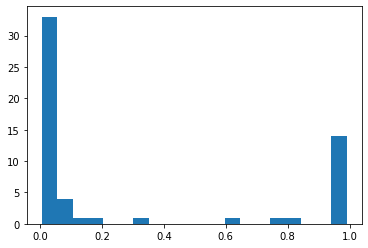

In [42]:
plt.hist(predictions, bins=20)
plt.show()

The continuous valued predictions coming from our model are generally quite decisive so tend to skew toward 0 or 1; however there are a few values between 0.1 and 0.9 where the model is less confident.

How you adjust the cutoff is completely dependent upon the problem space you are addressing and whether you want to have more likelihood of false positives or false negatives.

In the case of predicting malignant tumours we would rather err on the side of false positives, than false negatives, so we will be extremely conservative and report any prediction greater than 0.1 as malignant 

Where you define this cutoff is going be be based on your problem domain and whether you would prefer to err on the side of false negatives or false positives

In [43]:
pd.crosstab(index=test_data.iloc[:, 0], columns=np.where(predictions > 0.1, 1, 0), rownames=['actual'], colnames=['predictions'])

predictions,0,1
actual,,
0,36,4
1,1,16


Our confusion matrix is very interesting. We now have fewer correct predictions overall; however, for our problem domain this is a better result.

Of the 40 benign tumours, our model has correctly predicted 37 of them. The remaining 3 would be predicted as malignant. These are our false positives
Of the 17 malignant tumours, our model has correctly predicted all 17 of them. We have no false negatives within this test set.


---
<a id='cleanup'></a>

## (Optional) Clean-up

If you're finished with this predictor, please run the cell below.  This will remove the hosted endpoint you created and avoid any charges from a stray instance being left on.

In [44]:
xgb_predictor.delete_endpoint(delete_endpoint_config=True)

---
<a id ='hyperparameter_optimization'></a>


# Extensions

## Hyperparameter Optimization (HPO)

Machine learning is great at finding parameters which define patterns in our data, however there are many hyperparameters which govern how our machine learning algorithm will go about finding those parameters.

SageMaker's Hyperparameter optimization can assist in finding the best set of hyperparameters.

> Note that our current results are excellent, so hyperparameter optimization is unlikely to improve these; however, we will run through the process of hyperparameter optimization as it could be very relevant to your own dataset




#### Configure HPO job
First we set the hyperparameters that we do not want SageMaker Hyperparameter optimization to experiment with. These are the static hyperparameters

In [45]:
static_hyperparameters = {
    "objective" : "binary:logistic",
    "num_round" : "100"
}

We create an estimator that we will use for training and set the static hyperparameters for the training job

Again we will utilize spot instances to reduce costs

In [46]:
from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner

container = sagemaker.image_uris.retrieve('xgboost',boto3.Session().region_name,version='latest')

xgb_hpo = sagemaker.estimator.Estimator(container,
                                    role, 
                                    instance_count=1, 
                                    instance_type='ml.m4.xlarge',
                                    use_spot_instances=True,
                                    max_wait=900,
                                    max_run=600,
                                    output_path='s3://{}/{}/output'.format(bucket, prefix),
                                    sagemaker_session=sess)

xgb_hpo.set_hyperparameters(**static_hyperparameters)

Now we tell SageMaker which hyperparameters we want it to experiment with with the goal of finding the hyperparameter combination that yields the best performing model

In [47]:
tuned_hyperparameter_ranges = {'eta': ContinuousParameter(0.1, 0.5),
                        'min_child_weight': ContinuousParameter(1, 10),
                        'alpha': ContinuousParameter(0, 2),
                        'subsample': ContinuousParameter(0.5, 1),
                        'max_depth': IntegerParameter(5, 10)}

Define the hyperparameter tuning job

In [48]:
tuner = HyperparameterTuner(xgb_hpo,
                            objective_metric_name='validation:auc',
                            objective_type='Maximize',
                            hyperparameter_ranges=tuned_hyperparameter_ranges,
                            max_jobs=20,
                            max_parallel_jobs=3)

#### Run the hyperparameter tuning job

In [49]:
timestamp = time.strftime('-%Y%m%d%H%M', time.gmtime())

In [50]:
%time
tuner.fit({'train': s3_input_train, 'validation': s3_input_validation}, job_name='HPObreastCancer'+timestamp, include_cls_metadata=False)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs
...........................................................................................................................................................................................................................................................................................................................................!


### Check job name and status of HPO job

In [51]:
sage_client = boto3.Session().client('sagemaker')

hpo_job_name=tuner.latest_tuning_job.job_name
print(hpo_job_name)

sage_client.describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=hpo_job_name)['HyperParameterTuningJobStatus']


HPObreastCancer-202109060452


'Completed'

### Analyze tuning job results - after tuning job is completed
Please refer to "HPO_Analyze_TuningJob_Results.ipynb" to see example code to analyze the tuning job results.

However, if the job status is `Completed` and you really don't care about analysing the results of all the different hyperparameter combinations, the code below will return you the best job name and the best combination of hyperparameters found

In [52]:
tuning_job_result = sage_client.describe_hyper_parameter_tuning_job(HyperParameterTuningJobName=hpo_job_name)
best_job=tuning_job_result.get('BestTrainingJob',None)

best_job_name=best_job.get('TrainingJobName',None)
tuned_hyperparams=best_job.get('TunedHyperParameters',None)
print("Best job had name:",best_job_name)
print("Best hyperparameter combination:",tuned_hyperparams)

Best job had name: HPObreastCancer-202109060452-017-e4094caf
Best hyperparameter combination: {'alpha': '0.27296436677461466', 'eta': '0.1337078865525678', 'max_depth': '10', 'min_child_weight': '1.2807906208903201', 'subsample': '1.0'}


### Create a hosted endpoint from the best job results

Locate the S3 path to the model artifact

In [53]:
info = sage_client.describe_training_job(TrainingJobName=best_job_name)
model_data = info['ModelArtifacts']['S3ModelArtifacts']
print(model_data)

s3://sagemaker-ap-southeast-2-263461971145/sagemaker/xgboost-bc/output/HPObreastCancer-202109060452-017-e4094caf/output/model.tar.gz


Create a SageMaker model from the model artifact

In [54]:
primary_container = {
    'Image': container,
    'ModelDataUrl': model_data
}

model_name=best_job_name + '-model'

create_model_response = sage_client.create_model(
    ModelName = model_name,
    ExecutionRoleArn = role,
    PrimaryContainer = primary_container)

In [55]:
print(create_model_response['ModelArn'])

arn:aws:sagemaker:ap-southeast-2:263461971145:model/hpobreastcancer-202109060452-017-e4094caf-model


Create a configuration for a SageMaker hosted endpoint

In [56]:
endpoint_config_name = 'HPO-XGBoostEndpointConfig-' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print(endpoint_config_name)
create_endpoint_config_response = sage_client.create_endpoint_config(
    EndpointConfigName = endpoint_config_name,
    ProductionVariants=[{
        'InstanceType':'ml.t2.medium',
        'InitialVariantWeight':1,
        'InitialInstanceCount':1,
        'ModelName':model_name,
        'VariantName':'AllTraffic'}])

print("Endpoint Config Arn: " + create_endpoint_config_response['EndpointConfigArn'])

HPO-XGBoostEndpointConfig-2021-09-06-09-45-59
Endpoint Config Arn: arn:aws:sagemaker:ap-southeast-2:263461971145:endpoint-config/hpo-xgboostendpointconfig-2021-09-06-09-45-59


Create a SageMaker hosted endpoint using the configuration created above.
We will poll every 60 seconds until the endpoint is `InService`

In [57]:
endpoint_name = 'HPO-XGBoostEndpoint-' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print(endpoint_name)
create_endpoint_response = sage_client.create_endpoint(
    EndpointName=endpoint_name,
    EndpointConfigName=endpoint_config_name)
print(create_endpoint_response['EndpointArn'])

resp = sage_client.describe_endpoint(EndpointName=endpoint_name)
status = resp['EndpointStatus']
print("Status: " + status)

while status=='Creating':
    time.sleep(60)
    resp = sage_client.describe_endpoint(EndpointName=endpoint_name)
    status = resp['EndpointStatus']
    print("Status: " + status)

print("Arn: " + resp['EndpointArn'])
print("Status: " + status)

HPO-XGBoostEndpoint-2021-09-06-09-46-03
arn:aws:sagemaker:ap-southeast-2:263461971145:endpoint/hpo-xgboostendpoint-2021-09-06-09-46-03
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: InService
Arn: arn:aws:sagemaker:ap-southeast-2:263461971145:endpoint/hpo-xgboostendpoint-2021-09-06-09-46-03
Status: InService


Create a predictor (this is an object to make it simpler to make requests to an endpoint). 

In [58]:
xgb_predictor_hpo = sagemaker.predictor.Predictor(endpoint_name,
                               serializer = sagemaker.serializers.CSVSerializer(),
                               deserializer = sagemaker.deserializers.StringDeserializer())

As we did with our previous endpoint, we'll use a simple function to:

Loop over our test dataset

Extract the features for each sample

Retrieve the prediction for each sample by invoking the XGBoost endpoint

Collect predictions and convert from a python list to a NumPy array




In [59]:
# Create a list to hold all of our predictions using the HPO model
predictions_hpo = []

# Loop through the matrix of our test data samples, pulling out the features for each sample and running inference
# Note: dtest[i:i+1, 1:] is an vector of all the features for the sample i (without the first entry which is the label)
for i in range(dtest.shape[0]):
    sample_features=dtest[i:i+1, 1:]
    prediction=xgb_predictor_hpo.predict(sample_features)
    predictions_hpo.append(float(prediction))
       
# Convert our list of predictions to a numpy array
predictions_hpo = np.asarray(predictions_hpo)
display(predictions_hpo)

array([1.51427835e-02, 9.98799682e-01, 9.98390794e-01, 2.69252085e-03,
       4.72486310e-04, 9.98842835e-01, 9.98145461e-01, 9.22781110e-01,
       8.82549286e-01, 2.56969570e-03, 5.98644838e-02, 9.93565500e-01,
       1.47673870e-02, 9.91308689e-01, 2.34768237e-03, 9.98046756e-01,
       3.60325375e-03, 7.97041692e-04, 1.58516725e-03, 9.98299181e-01,
       1.19644580e-02, 2.17280863e-03, 9.98620033e-01, 2.12862948e-03,
       4.52401023e-03, 3.84570472e-03, 3.01286322e-03, 6.13746094e-03,
       6.44431449e-04, 9.98676717e-01, 2.23726546e-03, 1.32277550e-03,
       6.54150825e-03, 1.30471098e-03, 1.20148435e-03, 1.88924640e-03,
       6.73671961e-01, 2.52910051e-03, 9.99004543e-01, 1.56545192e-02,
       5.14501997e-04, 9.98597324e-01, 2.14958540e-03, 7.05454324e-04,
       2.30458025e-02, 1.91947613e-02, 1.82812556e-03, 9.66680981e-03,
       4.45992425e-02, 1.99557957e-03, 9.98816490e-01, 9.98842835e-01,
       2.66337365e-01, 3.07667311e-02, 9.12827207e-04, 2.08568922e-03,
      

How does our new model go at making predictions?

In [60]:
pd.crosstab(index=test_data.iloc[:, 0], columns=np.round(predictions_hpo), rownames=['actual'], colnames=['predictions'])

predictions,0.0,1.0
actual,,
0,39,1
1,1,16


We are getting the same results as we had in our initial model.
This is not unexpected, as our initial model had excellent results

What about if we shift the cutoff point for a positive result?

In [61]:
pd.crosstab(index=test_data.iloc[:, 0], columns=np.where(predictions_hpo > 0.1, 1, 0), rownames=['actual'], colnames=['predictions'])

predictions,0,1
actual,,
0,38,2
1,1,16


This is no better than our result before Hyperparameter Optimization.<br>
At this point we probably can't improve our model any further by optimizing the hyperparameters, so we know we need to look at the data. 
Perhaps we need to use domain knowledge to include extra relevant features.

---
<a id='cleanupfinal'></a>
### (Optional) Final Clean-up

If you're finished with this notebook, please run the cell below.  This will remove the hosted endpoint you created after the hyperparameter optimization stage; and avoid any charges from a stray instance being left on.

In [62]:
xgb_predictor_hpo.delete_endpoint(delete_endpoint_config=True)